In [2]:
!pip install ipynb
!pip install nbimporter
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_curve, auc
import seaborn as sns
import plotly.express as px
sns.set(palette='rainbow', context='talk')


import nbimporter
from EDA import vowelData
from EDA import irisData
from EDA import breastcancerData


### Chose the dataset

In [3]:
#call one of the function to load the dataset
#df_, x ,y = vowelData ()
df_, x ,y = irisData ()
#df_, x ,y = breastcancerData()

# Apply OCC-SVM

In [4]:
#for vowels dataset
#target = 'feature12'
#for iris and breast_cancer
target = 'target'

print("The dataset selected has shape: " + str(df_.shape) + " and for each class "+ str(Counter(df_[target])))

The dataset selected has shape: (150, 5) and for each class Counter({0: 50, 1: 50, 2: 50})


### For multi-class datasets we need to select 1 target class and then set an smaller amount of outliers

In [5]:
df = df_.copy()
df[target]= (df[target]==1)
df = df.drop(df[df[target] == False].sample(frac=0.80).index)
x = df.drop(columns=target)
y = df[target]
Counter(df[target])

Counter({False: 20, True: 50})

### Now we proceed with the OCC-SVM

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 56
The number of records in the test dataset is 14
The training dataset has 14 records for the majority class and 42 records for the minority class.


In [23]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
ds1_f1 = []

In [24]:
for kernel in classical_kernels:
    # Train the one class support vector machine (SVM) model
    one_class_svm = OneClassSVM(nu=0.2, kernel = kernel, gamma = 'auto').fit(X_train)
    # Predict the anomalies
    prediction = one_class_svm.predict(X_test)
    prediction = [False if i==-1 else True for i in prediction]
    print("{} kernel classification f1 score is {}".format(kernel,f1_score(y_test, prediction)))
    ds1_f1.append(f1_score(y_test, prediction))

linear kernel classification f1 score is 0.7999999999999999
poly kernel classification f1 score is 0.7999999999999999
rbf kernel classification f1 score is 0.8571428571428571
sigmoid kernel classification f1 score is 0.0


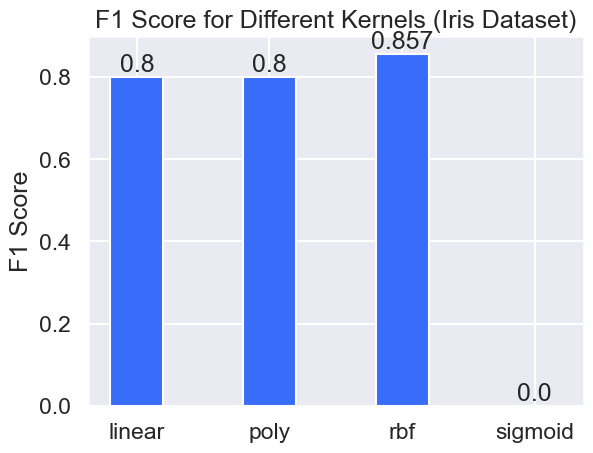

In [25]:
# Set the width of the bars
bar_width = 0.4

# Create a list of x positions for the bars
x_pos = range(len(classical_kernels))

# Create the bar plot
plt.bar(x_pos, ds1_f1, width=bar_width)

# Set the x-axis labels
plt.xticks(x_pos, classical_kernels)

# Set the y-axis label
plt.ylabel('F1 Score')

# Set the title of the graph
plt.title('F1 Score for Different Kernels (Iris Dataset)')

# Add the rounded values on top of each bar
for i, value in enumerate(ds1_f1):
    rounded_value = round(value, 3)  # Round off to three decimal points
    plt.text(i, value, str(rounded_value), ha='center', va='bottom')

# Show the plot
plt.show()

### Once we find the best performing kernal

In [27]:
 one_class_svm = OneClassSVM(nu=0.2, kernel = 'rbf', gamma = 'auto').fit(X_train)
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
prediction = [False if i==-1 else True for i in prediction]
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

       False       0.75      1.00      0.86         6
        True       1.00      0.75      0.86         8

    accuracy                           0.86        14
   macro avg       0.88      0.88      0.86        14
weighted avg       0.89      0.86      0.86        14



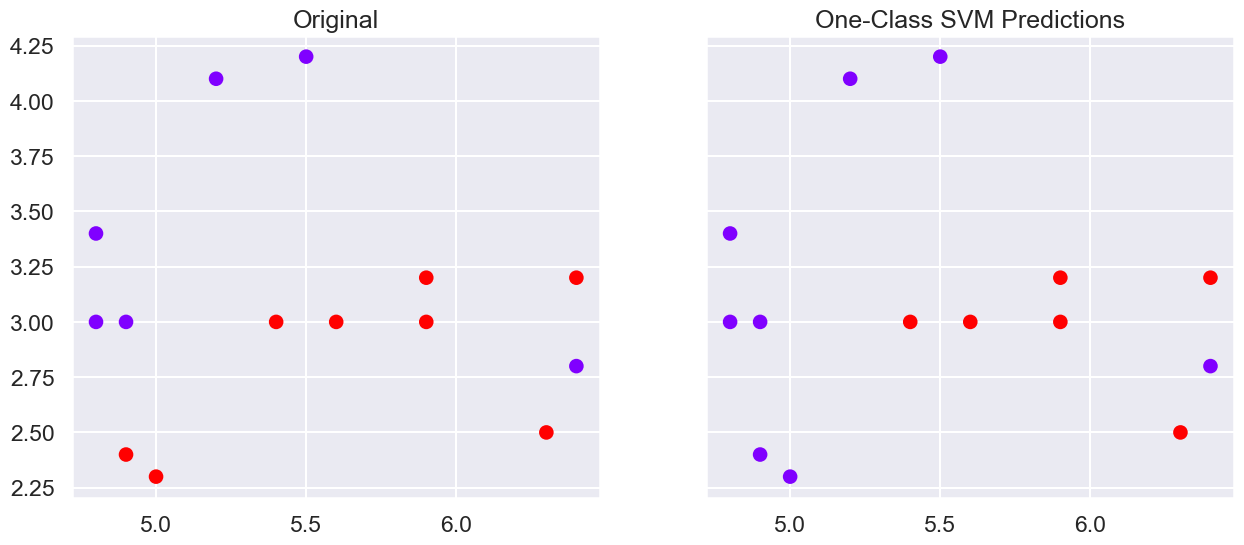

In [28]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(X_test)
df_test['y_test'] = y_test
df_test['one_class_svm_prediction'] = prediction
# Visualize the actual and predicted anomalies
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(15,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test[0], df_test[1], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test[0], df_test[1], c=df_test['one_class_svm_prediction'], cmap='rainbow')

In [29]:
train_prediction = one_class_svm.predict(X_train)

### ROC-curve

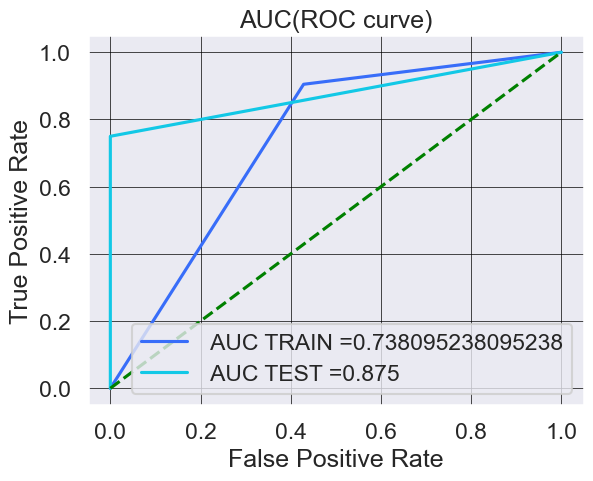

In [30]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, train_prediction)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()